In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

nlp = spacy.load('en_core_web_lg')

2022-09-24 00:57:23.578782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-24 00:57:23.578808: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/marko/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-24 00:57:26.314987: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-24 00:57:26.315008: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-24 00:

In [2]:
# df.to_pickle("./pickle_files/df_spojeni_vectors.pkl")
# df = pd.read_pickle("./pickle_files/df_spojeni_vectors.pkl")
# df.to_pickle("./pickle_files/df_odvojeni_vectors.pkl")
# df = pd.read_pickle("./pickle_files/df_odvojeni_vectors.pkl")
# df.to_pickle("./pickle_files/df_odvojeni_word_vectors.pkl")
df = pd.read_pickle("./pickle_files/df_odvojeni_word_vectors.pkl")
df = df.head(80000)

In [3]:
#padding vektora
def paddingEmbedded(a):

  b = np.zeros([len(a), len(max(a, key=lambda x: len(x))),300])
  for i, j in enumerate(a):
    if(len(j)==0):
      continue
    b[i][0:len(j)] = j
    b[i][len(j):] = np.zeros(300,)
  return b

# df['vectors'] = df['vectors'].apply(lambda x: np.array(list(map(lambda y: y.reshape(300,), np.stack(x)))))

vectorList = paddingEmbedded(df['vectors'].array)

## NN ALGORITHMS

In [4]:
training_size = 0.8

sentences = []
labels = []

for ind in df.index:
    sentences.append(vectorList[ind])
    labels.append(df['type'][ind])

In [5]:
from sklearn.model_selection import train_test_split
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(sentences, labels, test_size=1-training_size, random_state=42, stratify=labels)

In [6]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [7]:
encoder = OneHotEncoder()
training_labels = encoder.fit_transform(training_labels.reshape(-1,1)).toarray()
testing_labels = encoder.fit_transform(testing_labels.reshape(-1,1)).toarray()

In [8]:
# testing_sentences = np.array(list(testing_sentences))
# training_sentences = np.array(list(training_sentences))
testing_sentences = tf.convert_to_tensor(testing_sentences)
training_sentences = tf.convert_to_tensor(training_sentences)

2022-09-24 00:57:49.369449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-24 00:57:49.402422: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1728000000 exceeds 10% of free system memory.
2022-09-24 00:58:19.854150: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6912000000 exceeds 10% of free system memory.


In [9]:
classes = 4

filters = 32
pool_size = 2
kernel_size = 3

model = tf.keras.Sequential([
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Conv1D(filters, kernel_size, padding='valid',activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size),
    tf.keras.layers.LSTM(120,return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(classes,activation='softmax')
])
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [10]:
NEpoch = 32
batch_size = 32
history = model.fit(training_sentences, training_labels, batch_size=batch_size, epochs=NEpoch, validation_data=(testing_sentences, testing_labels))

Epoch 1/32
2000/2000 [==============================] - 49s 23ms/step - loss: 1.0630 - accuracy: 0.5040 - val_loss: 1.0567 - val_accuracy: 0.5117
Epoch 2/32
2000/2000 [==============================] - 38s 19ms/step - loss: 1.0555 - accuracy: 0.5130 - val_loss: 1.0539 - val_accuracy: 0.5114
Epoch 3/32
2000/2000 [==============================] - 40s 20ms/step - loss: 1.0554 - accuracy: 0.5125 - val_loss: 1.0522 - val_accuracy: 0.5129
Epoch 4/32
2000/2000 [==============================] - 42s 21ms/step - loss: 1.0530 - accuracy: 0.5140 - val_loss: 1.0539 - val_accuracy: 0.5133
Epoch 5/32
2000/2000 [==============================] - 42s 21ms/step - loss: 1.0531 - accuracy: 0.5146 - val_loss: 1.0519 - val_accuracy: 0.5170
Epoch 6/32
2000/2000 [==============================] - 42s 21ms/step - loss: 1.0517 - accuracy: 0.5145 - val_loss: 1.0504 - val_accuracy: 0.5161
Epoch 7/32
2000/2000 [==============================] - 44s 22ms/step - loss: 1.0513 - accuracy: 0.5163 - val_loss: 1.0513 -

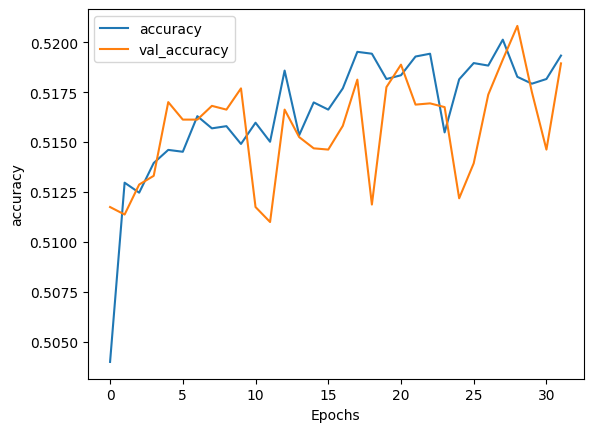

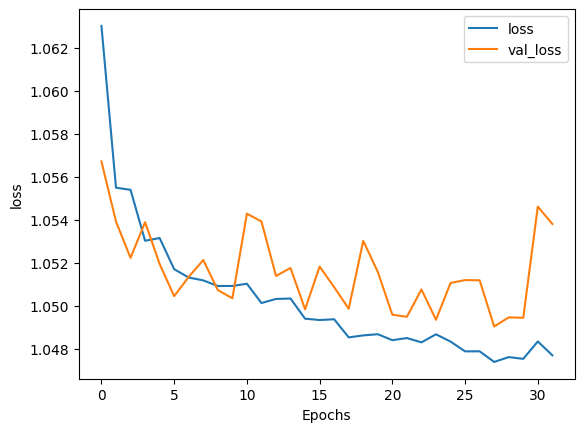

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
def paddingEmbedded(a):
  b = np.zeros([len(a), len(max(a, key=lambda x: len(x))), 300])
  for i, j in enumerate(a):
    if (len(j) == 0):
      continue
    b[i][0:len(j)] = j
    b[i][len(j):] = np.zeros(300,)
  return b

def word2vec(post):
  vecList = []
  # post = list(map(lambda x: x.split(),post))
  docs = nlp(post)
  for doc in docs:
    vecList.append(doc.vector)

  vecList=np.array(vecList)
  return np.array(vecList)



sentence = ["I fully believe power protector voice voiceless so spirit I present film hope recieve spirit compassion om mani padme hum yes right but time help come outside relationshippartner supportive helpful I think get right help critical finding good if do not feel worthy love difference I think jawz I think indicative deep issue long meet it mean friend lookingglass thank make point unfortunately corrupt christianity speak loud voice still small voice forget very christian today this curse I get to tell people prefer remain stuck neurosis excuse of course spite scar I ve I know painful callie honestly I think dodged bullet I m sure he s good person sound emotional mature being involve you guy singe song I ve research heuristic mental shortcuts cognitive bias explain lot people for principle I empathize sentiment I think truly religion contain need society easily manipulate control this dualistic I think forget type make person emotional social competency past hurt issue value meme etc I see experiment crowd I do not feel rare I feel thank uk sound like reasonable compassionate person I think neitzsche quote beware fight monster lest process appropriate here colorado it surprise learn cognitive brain science discover human actually hard - wire empathy read golemans social intelligence help understand you understand aegis blame yes like inhuman monster try justify marginalize human people like do not understand you know idea riddle fallacy linquistic manipulation is not worth time continue conversation hopefully year pass learn think an elephant swallow boa constrictor love book I cry little end thoughtful philosophy sure I like line the little prince signature block I use accord logic tolerance accept intolerance consider tolerant homosexuality violent behavior conflate extremely okay guy record I think healthy debate help forward simple heuristic accompany cognitive bias prevalent religion critical thinking look like explain I m sorry I do not notice post do not mean ignore the teleological argument definitely major flaw conclusion draw okay attribute else quote second problem this post logical fallacy introduce straw - man no problem look light moment re - frame argument no introduce idea tolerant clever use slippery slope do not blame touch gay marriage good I far faith reason inherently contradictory I word post way I you understand I spend life study religion no suppose know inner council can not people aware communicate telepathically year disguise regular folk so get decide good and I would not word like logic religion concern little religion stand critical inquiry old school infj theme song veteran psychic war blue oyster cult okay world bullshit I m go to change frame reference up point I ve operate think world vampire define get olderfor life I try squeeze role I think I need order I think people know like you plate pardner pretty typical ill bet stuff go inside reasonably articulate this I love I like card do not write creative after argument wife I find little dog I write run away love thread over year I practice religion philosophy I think infj mean explorer extent during phase exploration I practice I think I hate crap meaningless usually people feel good the truth people self - center do not understand love I understand it bother lot I walk store feel angry judgmental add sap energy feeling I do not like the great sage linus van pelt say I love mankind people I can not stand I find end individually I love people group funny come long way sometimes I try talk like oh man do not know sure chance come accord cognitive brain science truly tune human synchrony brain wave with discovery mirror neuron look like stumble buddhist first noble truth okay I m go to sound lame go you go find keep change grow nature ever try friend stray cat the rule apply do not chase run provide safe friendly harbor watch quickly affectionate well like someones post thank un thank thank oh chazz that feeling come go I would not mean ever I remember I feel like I belong as child I impression presence okay totally agree post I could not help get visual intimidate typist I see roz monsters inc it take little time tell difference anxious perception clear intuition that say year I manage screw royally time great movie I think movie move wing of desire this film old school style direct wim wender feature talent I m sure experience maybe I m middle aged I thing way I musician artist salesman soldier nurse cna technician christian buddhist I find mirror neuron read daniel golemans social intelligence credit research go italian research scientist escape ai not funive reading mirror neuron genuinely engage human brain actually sync now have compile information link mb type soma type I wonder expectation little unrealistic time sometimes I feel emotionally raw wound need withdraw oddly time like little",
            "I really enjoyed this anime, but some of the characters were a bit annoying. Also, it would have been a lot better if the ending wasn't so horrible.",
            "From time to time, I have the urge to punch a random stranger on the street. My intrusive thoughts are hard to control, and one time, when I couldn't win in a fight against them, I ended up in prison. I still don't remember what i did. The rumor has it that I killed them."]
embedded = []
for post in sentence:
  embedded.append(word2vec(post))

embedded = np.array(embedded)

embedded = paddingEmbedded(embedded)

print(model.predict(embedded))
## correct is
## [2]
## [0]

/tmp/ipykernel_23205/3698993887.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  embedded = np.array(embedded)


1/1 [==============================] - 3s 3s/step
[[0.03317978 0.0390813  0.6953137  0.2324252 ]
 [0.04483764 0.12626925 0.46908596 0.3598071 ]
 [0.04567244 0.11235766 0.49184078 0.3501291 ]]


In [13]:
print(max(history.history['val_accuracy']))
print(min(history.history['val_loss']))


0.5208125114440918
1.0490292310714722
